# Bidirectional LSTM for Stance Detection with glove embeddings

In this document, we train a bidirectional LSTM using glove word vectors, instead of DistilBERT word embeddings because of the memory limitations.

We start by installing and importing the required libraries.

In [ ]:
!pip install -U datasets
!pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 1.7 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
import re
import numpy as np
import pandas as pd
from datasets import Dataset, DatasetDict, ClassLabel
from torch.utils.data import DataLoader, TensorDataset, random_split
from evaluate import load
from sklearn.model_selection import train_test_split


In [ ]:
from keras.initializers import Constant
from keras.preprocessing.text import one_hot, Tokenizer
from keras.models import Sequential,Model
from keras.layers import *
from keras import regularizers
from tensorflow.keras.regularizers import l2

from numpy import array
from numpy import asarray

Both the dataset and glove embeddings are stored in Google Drive. To run this code on Google Colab, path should be modified according to the location of the dataset.

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)
dataset_path = '/content/drive/MyDrive/CS533_Shared/project/dataset/dataset_merged.csv'
glove_path = "/content/drive/My Drive/CS533_Shared/project/implementation/glove.42B.300d.txt"


Mounted at /content/drive


Some helper functions:

In [ ]:
#Preprocess the tweets to remove mentions and SemEval tag
def preprocess_data(data):
  cleaned_data = []

  for sent in data:
    sent = sent.lower()
    cleaned_sent = re.sub("@[A-Za-z0-9]+","", sent)  # Removing mentions
    cleaned_sent = cleaned_sent.replace('#SemST','') #Removing SemEval tag
    cleaned_data = np.append(cleaned_data,cleaned_sent)

  return cleaned_data

In [ ]:
#Loads pre-defined word embeddings from GloVe and saves in a dictionary
def load_glove_vectors(word_dict):
  embeddings_index = {} #saving embeddings for each word in this dictionary

  #read file and add words to dictionary
  f = open(glove_path)
  for line in f:
    values = line.split()
    word = values[0]
    if word not in word_dict.keys():
      continue
    coefs = asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
  f.close()

  embeddings_found = len(embeddings_index)
  print('Loaded %s word vectors.' % embeddings_found)

  #if a word is not in GloVe word vectors, assign its vector to 0
  embedding_dimension = len(list(embeddings_index.values())[0]) #getting the dimension of an embedding
  for word in word_dict.keys():
    if word not in embeddings_index.keys():
      #if a word does not exist in glove, set it to a zero vector of size (embedding_dimension)
      embeddings_index[word] = np.zeros(embedding_dimension)

  #display how many words are not in glove
  print('Initialized zero vectors for %s words.' % (len(embeddings_index) - embeddings_found) )

  return embeddings_index, embedding_dimension

In [ ]:
#read the word dictionary from before and return an embedding matrix
def create_embedding_matrix(embeddings, vocab_size, embedding_dimension, word_dict):
  embedding_matrix = np.zeros((vocab_size, embedding_dimension))
  for word, i in word_dict.items():
    embedding_vector = embeddings.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector
  return embedding_matrix

In [ ]:
#find the length of the longest sentence
def find_max_sent_length(sent_list):
  max = 0
  for sent in sent_list:
    if len(sent) > max:
      max = len(sent)
  return max

In [ ]:
#convert 'stance' column values to numeric values
def map_stance_to_numeric(stance):
    if stance == 'favor':
        return 1
    elif stance == 'against':
        return 2
    elif stance == 'none':
        return 0
    else:
        return None

In [ ]:
#read the dataset from the file into a DataFrame
dataset_df = pd.read_csv(dataset_path)

#converting column names to lowercase
dataset_df.columns = dataset_df.columns.str.lower()

In [ ]:
# splitting data into train and test
dataset_df, testset_df = train_test_split(dataset_df, test_size=0.1, random_state=42)

In [ ]:
#preprocesssing all tweets and stances on the train dataset
tweet_list = dataset_df['tweet'].tolist()
stance_list = dataset_df['stance'].tolist()
processed_tweet_list = preprocess_data(tweet_list)
processed_stance_list = preprocess_data(stance_list)

#update the 'Tweet' column in the DataFrame
dataset_df['tweets'] = processed_tweet_list
dataset_df['stance'] = processed_stance_list

In [ ]:
#preprocessing all tweets and stances on the test dataset
tweet_list = testset_df['tweet'].tolist()
stance_list = testset_df['stance'].tolist()
processed_tweet_list = preprocess_data(tweet_list)
processed_stance_list = preprocess_data(stance_list)

# Update the 'Tweet' column in the DataFrame
testset_df['tweets'] = processed_tweet_list
testset_df['stance'] = processed_stance_list

In [ ]:
#create the new 'stance_num' column
dataset_df['labels'] = dataset_df['stance'].apply(map_stance_to_numeric)
testset_df['labels'] = testset_df['stance'].apply(map_stance_to_numeric)

In [ ]:
#tokenize the tweets
t = Tokenizer()
t.fit_on_texts(testset_df['tweets'])

encoded_all = t.texts_to_sequences(testset_df['tweets'])
max_length = find_max_sent_length(encoded_all)

In [ ]:
#create a new DataFrame with only 'tweet' and 'stance_num' columns
train_and_validation_df = dataset_df[['tweets', 'labels']]
test_df = testset_df[['tweets', 'labels']]

#separating training data into train and validation
train_df = train_and_validation_df.sample(frac=0.9, random_state=25)
validation_df = train_and_validation_df.drop(train_df.index)
train_df = train_df.reset_index(drop=True)
validation_df = validation_df.reset_index(drop=True)

In [ ]:
#tokenize the tweets for training, test and validation
#then add padding to have the same dimensions with the sentence with the max length
encoded_X_train = t.texts_to_sequences(train_df["tweets"])
encoded_X_val = t.texts_to_sequences(validation_df["tweets"])
train_x = tf.keras.utils.pad_sequences(encoded_X_train, maxlen=max_length, padding='post')
val_x = tf.keras.utils.pad_sequences(encoded_X_val, maxlen=max_length, padding='post')
encoded_X_test = t.texts_to_sequences(test_df["tweets"])
test_x = tf.keras.utils.pad_sequences(encoded_X_test, maxlen=max_length, padding='post')

#save the word_dict, which will be used while loading glove embeddings
word_dict = t.word_index

In [ ]:
from tensorflow.keras.utils import to_categorical

#we will use categorical cross entropy loss, so we need to convert the labels to one-hot encoding
train_y = to_categorical(train_df["labels"], num_classes=3)
val_y = to_categorical(validation_df["labels"], num_classes=3)
test_y = to_categorical(test_df["labels"], num_classes=3)

In [ ]:
vocab_size = len(word_dict) + 1

#for all words in the dictionary, get a glove embedding and return glove embeddings dictionary
glove_embeddings_dict, embedding_dim = load_glove_vectors(word_dict)

#embedding matrix where each row represents a word embedding. size: (vocab_size x embedding dimension)
embedding_matrix = create_embedding_matrix(glove_embeddings_dict, vocab_size, embedding_dim, word_dict)

Loaded 9009 word vectors.
Initialized zero vectors for 1901 words.


In [ ]:
#the variables for dropout rate and regularization
dropout_rate = 0.5
l2_strength = 0.001

In [ ]:
#creating the structure of the model
bidirectional_model_2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size,
                              embedding_dim,
                              embeddings_initializer=Constant(embedding_matrix),
                              input_length=max_length,
                              trainable=False),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, dropout=dropout_rate, recurrent_dropout=dropout_rate, kernel_regularizer=l2(l2_strength), recurrent_regularizer=l2(l2_strength))),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=l2(l2_strength)),
    tf.keras.layers.Dropout(rate=dropout_rate),
    tf.keras.layers.Dense(3, activation='softmax', kernel_regularizer=l2(l2_strength))
])

In [ ]:
#compiling the model
bidirectional_model_2.compile(optimizer='adam',
                       loss='categorical_crossentropy',
                       metrics=[
                           'accuracy',
                           tf.keras.metrics.Precision(name='precision'),
                           tf.keras.metrics.Recall(name='recall'),
                           tf.keras.metrics.F1Score(name='f1_score')
                       ])

In [ ]:
#showing the details of the model to check the shape and number of parameters for each layer
bidirectional_model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 58, 300)           3273300   
                                                                 
 bidirectional (Bidirection  (None, 256)               439296    
 al)                                                             
                                                                 
 dense (Dense)               (None, 64)                16448     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                                 
Total params: 3729239 (14.23 MB)
Trainable params: 455939 (1.74 MB)
Non-trainable params: 3273300 (12.49 MB)
_____________

In [ ]:
#train the model
train_history1 = bidirectional_model_2.fit(train_x,
                           train_y,
                           validation_data = (val_x, val_y),
                           batch_size = 32,
                           epochs = 20)

Epoch 1/20
733/733 [==============================] - 260s 341ms/step - loss: 1.0531 - accuracy: 0.5498 - precision: 0.5830 - recall: 0.4003 - f1_score: 0.3751 - val_loss: 0.8795 - val_accuracy: 0.6004 - val_precision: 0.6358 - val_recall: 0.5213 - val_f1_score: 0.4074
Epoch 2/20
733/733 [==============================] - 248s 339ms/step - loss: 0.8819 - accuracy: 0.5853 - precision: 0.6214 - recall: 0.4880 - f1_score: 0.4035 - val_loss: 0.8400 - val_accuracy: 0.6115 - val_precision: 0.6426 - val_recall: 0.5578 - val_f1_score: 0.4124
Epoch 3/20
733/733 [==============================] - 256s 350ms/step - loss: 0.8590 - accuracy: 0.5947 - precision: 0.6276 - recall: 0.5069 - f1_score: 0.4066 - val_loss: 0.8586 - val_accuracy: 0.5762 - val_precision: 0.6088 - val_recall: 0.5317 - val_f1_score: 0.3644
Epoch 4/20
733/733 [==============================] - 247s 337ms/step - loss: 0.8508 - accuracy: 0.5972 - precision: 0.6301 - recall: 0.5104 - f1_score: 0.4091 - val_loss: 0.8322 - val_accur

In [ ]:
train_history1 = train_history1.history

Text(0, 0.5, 'Metrics')

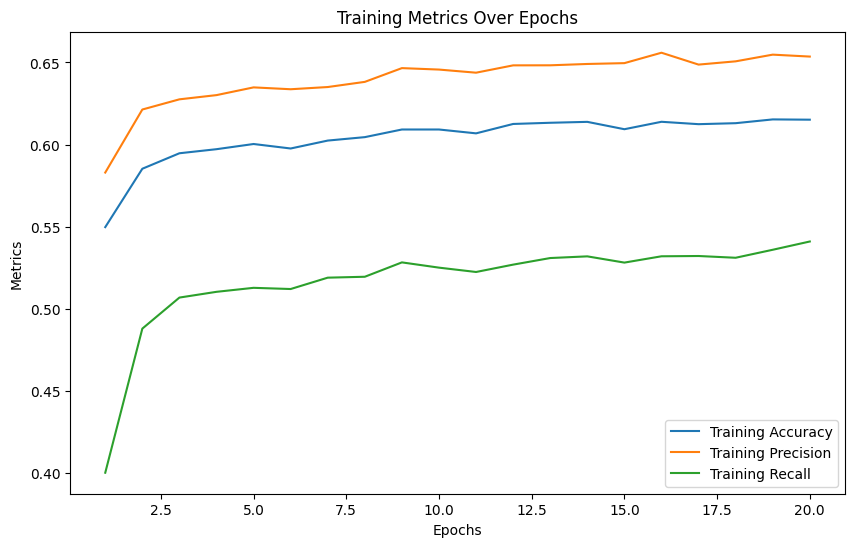

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_history1['accuracy']) + 1)

#plotting
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_history1['accuracy'], label='Training Accuracy')
plt.plot(epochs, train_history1['precision'], label='Training Precision')
plt.plot(epochs, train_history1['recall'], label='Training Recall')
plt.legend()

plt.title('Training Metrics Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Metrics')

### TESTING

In [ ]:
#test the model
test_history1 = bidirectional_model_2.evaluate(test_x, test_y, verbose = 1)

91/91 [==============================] - 3s 32ms/step - loss: 0.7970 - accuracy: 0.6287 - precision: 0.6607 - recall: 0.5523 - f1_score: 0.4838
